In [1]:
import pandas as pd
import openai
import numpy as np
import time

import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('df_template.csv')
df['date'] = pd.to_datetime(df['date'])
#df.set_index('date', inplace=True)
df.rename(columns={'date':'Date'}, inplace=True)
df.head(2)

,Date,title,governor,tokens,hawk/dove,Inflation,Interest Rates,Economic Growth,Employment,speech_category,governor_clean
0,2005-01-07,Interpreting Labor Market Statistics in the Co...,"Vice Chairman Roger W. Ferguson, Jr.",1550,0.0,0,0,0,1,Generic,"Roger W. Ferguson, Jr."
1,2005-01-18,The Economy and Challenges in Retirement Savings,Governor Susan Schmidt Bies,2000,0.0,1,1,1,0,Generic,Susan S. Bies


In [3]:
price_list_rates = ["3m", "6m","2yr", "5yr", "10yr", "30yr", "1yr"]
price_list_all = ["1yr","2yr", "5yr", "10yr", "30yr", "s&p500", "3m", "6m", "VIX"]

df_complete = df[["Date", "hawk/dove"]]

for i in price_list_rates:
    d = pd.read_csv(f"{i}.csv")
    d["Date"] = pd.to_datetime(d["Date"])
    d = d[["Date", " Open"]]
    d = d.rename(columns={" Open": f"{i}"})
    df_complete = pd.merge(df_complete, d, on="Date", how="outer")

df_complete["hawk/dove"].fillna(0, inplace=True)
df_complete = df_complete.sort_values('Date')
df_complete["Date"] = pd.to_datetime(df_complete["Date"])
df_complete = df_complete.set_index("Date")
df_complete.dropna(inplace=True)
df_complete.head()

/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/1133202565.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])


/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/1133202565.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/1133202565.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/1133202565.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/1133202565.py:8: 

,hawk/dove,3m,6m,2yr,5yr,10yr,30yr,1yr
Date,,,,,,,,
2008-05-28,0.00,1.875,1.956,2.510,3.227,3.920,4.642,1.900
2008-05-29,0.00,1.885,1.997,2.637,3.335,4.004,4.694,1.956
2008-05-30,0.00,1.913,2.026,2.698,3.723,4.076,4.752,1.956
2008-06-02,0.00,1.889,2.023,2.641,3.414,4.049,4.710,1.956
2008-06-03,-0.25,1.905,2.039,2.507,3.279,3.962,4.672,2.089


In [30]:
window = "14D" #I tried 10, 30
df_complete["HD_Score"] = df_complete["hawk/dove"].rolling(window).mean()
df_complete.dropna(inplace=True)

In [31]:
shift1 = 1
shift2 = 7
shift3 = 14
shift4 = 50

for i in price_list_rates:
    d = pd.read_csv(f"{i}.csv")
    d["Date"] = pd.to_datetime(d["Date"])
    d.set_index("Date", inplace=True)
    df_complete[f"{i}_{shift1}"] = d[" Open"].pct_change(-shift1)
    df_complete[f"{i}_{shift2}"] = d[" Open"].pct_change(-shift2)
    df_complete[f"{i}_{shift3}"] = d[" Open"].pct_change(-shift3)
    df_complete[f"{i}_{shift4}"] = d[" Open"].pct_change(-shift4)
    if i != "1yr":
        df_complete.dropna(inplace=True)

df_complete.shape

/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/4142412218.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/4142412218.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/4142412218.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["Date"] = pd.to_datetime(d["Date"])
/var/folders/sw/lwscf3w57bz06p9m9g2_5q1r0000gn/T/ipykernel_82309/4142412218.py:8: 

(3246, 45)

In [32]:
#interest rate difference between 30 and 3 year treasuries
spreads = ["T10Y2Y", "T10Y3M"]
for i in spreads:
    d = pd.read_csv(f"{i}.csv")
    d["DATE"] = pd.to_datetime(d["DATE"])
    d.set_index("DATE", inplace=True)
    d[f"{i}"] = d[f"{i}"].replace('.', np.nan)
    d[f"{i}"].interpolate(inplace=True)
    d[f"{i}"] = d[f"{i}"].astype(float)
    df_complete[f"{i}_{shift1}"] = d[f"{i}"].shift(shift1)
    df_complete[f"{i}_{shift2}"] = d[f"{i}"].shift(shift2)
    df_complete[f"{i}_{shift3}"] = d[f"{i}"].shift(shift3)
    df_complete[f"{i}_{shift4}"] = d[f"{i}"].shift(shift4)
    df_complete.dropna(inplace=True)

df_complete.shape

(3246, 45)

In [33]:
import statsmodels.api as sm

# define the list of columns to iterate over
prices_list = ["3m", "6m", "1yr","2yr", "5yr", "10yr", "30yr", "T10Y2Y", "T10Y3M"]

# create empty lists to store the results
rsquared_list_shift1 = []
hd_coeff_list_shift1 = []
hd_pvalue_list_shift1 = []
residuals_list_shift1 = []
pred_list_shift1 = []

rsquared_list_shift2 = []
hd_coeff_list_shift2 = []
hd_pvalue_list_shift2 = []
residuals_list_shift2 = []
pred_list_shift2 = []

rsquared_list_shift3 = []
hd_coeff_list_shift3 = []
hd_pvalue_list_shift3 = []
residuals_list_shift3 = []
pred_list_shift3 = []

rsquared_list_shift4 = []
hd_coeff_list_shift4 = []
hd_pvalue_list_shift4 = []
residuals_list_shift4 = []
pred_list_shift4 = []

# iterate over the columns in prices_list
for col in prices_list:
        # define the dependent and independent variables
        y_shift1 = df_complete[f"{col}_{shift1}"]
        y_shift2 = df_complete[f"{col}_{shift2}"]
        y_shift3 = df_complete[f"{col}_{shift3}"]
        y_shift4 = df_complete[f"{col}_{shift4}"]

        x = df_complete['HD_Score']

        # add a constant to the independent variable
        x = sm.add_constant(x)

        # perform the regression for shift1
        model_shift1 = sm.OLS(y_shift1, x).fit()

        # append the results to the lists for shift1
        rsquared_list_shift1.append(model_shift1.rsquared)
        hd_coeff_list_shift1.append(model_shift1.params[1])
        hd_pvalue_list_shift1.append(model_shift1.pvalues[1])
        residuals_list_shift1.append(model_shift1.resid)
        pred_list_shift1.append(model_shift1.predict(x))

        # perform the regression for shift2
        model_shift2 = sm.OLS(y_shift2, x).fit()

        # append the results to the lists for shift2
        rsquared_list_shift2.append(model_shift2.rsquared)
        hd_coeff_list_shift2.append(model_shift2.params[1])
        hd_pvalue_list_shift2.append(model_shift2.pvalues[1])
        residuals_list_shift2.append(model_shift2.resid)
        pred_list_shift2.append(model_shift2.predict(x))

        # perform the regression for shift3
        model_shift3 = sm.OLS(y_shift3, x).fit()

        # append the results to the lists for shift3
        rsquared_list_shift3.append(model_shift3.rsquared)
        hd_coeff_list_shift3.append(model_shift3.params[1])
        hd_pvalue_list_shift3.append(model_shift3.pvalues[1])
        residuals_list_shift3.append(model_shift3.resid)
        pred_list_shift3.append(model_shift3.predict(x))

        # perform the regression for shift4
        model_shift4 = sm.OLS(y_shift4, x).fit()

        # append the results to the lists for shift4
        rsquared_list_shift4.append(model_shift4.rsquared)
        hd_coeff_list_shift4.append(model_shift4.params[1])
        hd_pvalue_list_shift4.append(model_shift4.pvalues[1])
        residuals_list_shift4.append(model_shift4.resid)
        pred_list_shift4.append(model_shift4.predict(x))
        
# print the results for shift1
for i in range(len(prices_list)):
        print(f"{prices_list[i]} ({shift1}d): R-squared = {rsquared_list_shift1[i]}, HD_score coefficient = {hd_coeff_list_shift1[i]}, p-value smaller than 0.05 = {hd_pvalue_list_shift1[i] < 0.05}")

3m (1d): R-squared = 0.0005523837233925022, HD_score coefficient = -0.27160715503605715, p-value smaller than 0.05 = False
6m (1d): R-squared = 4.6821354360848666e-05, HD_score coefficient = 0.1753036738141511, p-value smaller than 0.05 = False
1yr (1d): R-squared = 5.956092048631234e-05, HD_score coefficient = 0.39113464334479864, p-value smaller than 0.05 = False
2yr (1d): R-squared = 0.0017312688569786072, HD_score coefficient = 0.049521456025243875, p-value smaller than 0.05 = True
5yr (1d): R-squared = 0.0022798339708772764, HD_score coefficient = 0.042790090279375644, p-value smaller than 0.05 = True
10yr (1d): R-squared = 0.002233471439260226, HD_score coefficient = 0.030038093480999884, p-value smaller than 0.05 = True
30yr (1d): R-squared = 0.001404203120355274, HD_score coefficient = 0.016661347526155404, p-value smaller than 0.05 = True
T10Y2Y (1d): R-squared = 0.07491347703300366, HD_score coefficient = -5.600360251850177, p-value smaller than 0.05 = True
T10Y3M (1d): R-squ

In [34]:
# print the results for shift2
for i in range(len(prices_list)):
        print(f"{prices_list[i]} ({shift2}d): R-squared = {rsquared_list_shift2[i]}, HD_score coefficient = {hd_coeff_list_shift2[i]}, p-value smaller than 0.05 = {hd_pvalue_list_shift2[i] < 0.05}")

3m (7d): R-squared = 0.00020968456041536854, HD_score coefficient = 0.34207673151211326, p-value smaller than 0.05 = False
6m (7d): R-squared = 0.0003200376847126707, HD_score coefficient = 0.3123786162830584, p-value smaller than 0.05 = False
1yr (7d): R-squared = 0.00021606131639684278, HD_score coefficient = 0.5132205545183823, p-value smaller than 0.05 = False
2yr (7d): R-squared = 0.008012748303791062, HD_score coefficient = 0.2450466475085116, p-value smaller than 0.05 = True
5yr (7d): R-squared = 0.004703738806874136, HD_score coefficient = 0.14539398374423435, p-value smaller than 0.05 = True
10yr (7d): R-squared = 0.0032903451890550217, HD_score coefficient = 0.0896123997004333, p-value smaller than 0.05 = True
30yr (7d): R-squared = 0.002773139910053346, HD_score coefficient = 0.057908045346325814, p-value smaller than 0.05 = True
T10Y2Y (7d): R-squared = 0.06994338661892396, HD_score coefficient = -5.390762000767059, p-value smaller than 0.05 = True
T10Y3M (7d): R-squared = 

In [35]:
y_shift1 = df_complete[f"{col}_{shift1}"]
y_shift2 = df_complete[f"{col}_{shift2}"]
y_shift3 = df_complete[f"{col}_{shift3}"]
y_shift4 = df_complete[f"{col}_{shift4}"]

In [36]:
# print the results for shift2
for i in range(len(prices_list)):
        print(f"{prices_list[i]} ({shift3}d): R-squared = {rsquared_list_shift3[i]}, HD_score coefficient = {hd_coeff_list_shift3[i]}, p-value smaller than 0.05 = {hd_pvalue_list_shift3[i] < 0.05}")


3m (14d): R-squared = 7.372327228405418e-05, HD_score coefficient = 0.27100181352464076, p-value smaller than 0.05 = False
6m (14d): R-squared = 0.00024804877548700865, HD_score coefficient = 0.40545807548982166, p-value smaller than 0.05 = False
1yr (14d): R-squared = 0.0002412228256325477, HD_score coefficient = 0.5751523759607859, p-value smaller than 0.05 = False
2yr (14d): R-squared = 0.007828338193971773, HD_score coefficient = 0.3332044454189226, p-value smaller than 0.05 = True
5yr (14d): R-squared = 0.0016699512199268574, HD_score coefficient = 0.11816057357612178, p-value smaller than 0.05 = True
10yr (14d): R-squared = 0.0012499438432509447, HD_score coefficient = 0.07171201254580252, p-value smaller than 0.05 = True
30yr (14d): R-squared = 0.0020939086635242132, HD_score coefficient = 0.06602928860019798, p-value smaller than 0.05 = True
T10Y2Y (14d): R-squared = 0.06213200322027734, HD_score coefficient = -5.057282433324144, p-value smaller than 0.05 = True
T10Y3M (14d): R

In [37]:
# create a dictionary with the data for shift1
data_shift1 = {'R-squared': rsquared_list_shift1[:-2], 'HD_score coefficient': hd_coeff_list_shift1[:-2], 'p-value': np.round(hd_pvalue_list_shift1[:-2], 3)}
# create the dataframe for shift1
df_shift_1 = pd.DataFrame(data_shift1, index=prices_list[:-2])
df_shift_1.to_csv('df_shift_1_14d.csv')

# create a dictionary with the data for shift2
data_shift2 = {'R-squared': rsquared_list_shift2[:-2], 'HD_score coefficient': hd_coeff_list_shift2[:-2], 'p-value': np.round(hd_pvalue_list_shift2[:-2], 3)}
# create the dataframe for shift2
df_shift_2 = pd.DataFrame(data_shift2, index=prices_list[:-2])
df_shift_2.to_csv('df_shift_2_14d.csv')

# create a dictionary with the data for shift3
data_shift3 = {'R-squared': rsquared_list_shift3[:-2], 'HD_score coefficient': hd_coeff_list_shift3[:-2], 'p-value': np.round(hd_pvalue_list_shift3[:-2], 3)}
# create the dataframe for shift3
df_shift_3 = pd.DataFrame(data_shift3, index=prices_list[:-2])
df_shift_3.to_csv('df_shift_3_14d.csv')

# create a dictionary with the data for shift4
data_shift4 = {'R-squared': rsquared_list_shift4[:-2], 'HD_score coefficient': hd_coeff_list_shift4[:-2], 'p-value': np.round(hd_pvalue_list_shift4[:-2], 3)}
# create the dataframe for shift4
df_shift_4 = pd.DataFrame(data_shift4, index=prices_list[:-2])
df_shift_4.to_csv('df_shift_4_14d.csv')

In [38]:
# create a dictionary with the data for shift1
data_shift1 = {'R-squared': rsquared_list_shift1[-2:], 'HD_score coefficient': hd_coeff_list_shift1[-2:], 'p-value': np.round(hd_pvalue_list_shift1[-2:], 3)}
# create the dataframe for shift1
df_shift_1 = pd.DataFrame(data_shift1, index=prices_list[-2:])
df_shift_1.to_csv('df_shift_1_14d_diff.csv')

# create a dictionary with the data for shift2
data_shift2 = {'R-squared': rsquared_list_shift2[-2:], 'HD_score coefficient': hd_coeff_list_shift2[-2:], 'p-value': np.round(hd_pvalue_list_shift2[-2:], 3)}
# create the dataframe for shift2
df_shift_2 = pd.DataFrame(data_shift2, index=prices_list[-2:])
df_shift_2.to_csv('df_shift_2_14d_diff.csv')

# create a dictionary with the data for shift3
data_shift3 = {'R-squared': rsquared_list_shift3[-2:], 'HD_score coefficient': hd_coeff_list_shift3[-2:], 'p-value': np.round(hd_pvalue_list_shift3[-2:], 3)}
# create the dataframe for shift3
df_shift_3 = pd.DataFrame(data_shift3, index=prices_list[-2:])
df_shift_3.to_csv('df_shift_3_14d_diff.csv')

# create a dictionary with the data for shift4
data_shift4 = {'R-squared': rsquared_list_shift4[-2:], 'HD_score coefficient': hd_coeff_list_shift4[-2:], 'p-value': np.round(hd_pvalue_list_shift4[-2:], 3)}
# create the dataframe for shift4
df_shift_4 = pd.DataFrame(data_shift4, index=prices_list[-2:])
df_shift_4.to_csv('df_shift_4_14d_diff.csv')

In [39]:
# print the results for shift2
for i in range(len(prices_list)):
        print(f"{prices_list[i]} ({shift4}d): R-squared = {rsquared_list_shift4[i]}, HD_score coefficient = {hd_coeff_list_shift4[i]}, p-value smaller than 0.05 = {hd_pvalue_list_shift4[i] < 0.05}")

3m (50d): R-squared = 0.0015599124942500264, HD_score coefficient = 3.5615799934806787, p-value smaller than 0.05 = True
6m (50d): R-squared = 0.0039761904907215095, HD_score coefficient = 2.69246119487177, p-value smaller than 0.05 = True
1yr (50d): R-squared = 0.0017761338356503398, HD_score coefficient = 2.13240553296374, p-value smaller than 0.05 = True
2yr (50d): R-squared = 0.04662826236417239, HD_score coefficient = 1.6391644281901652, p-value smaller than 0.05 = True
5yr (50d): R-squared = 0.0062244782783204, HD_score coefficient = 0.4765855623192501, p-value smaller than 0.05 = True
10yr (50d): R-squared = 0.008134112095452006, HD_score coefficient = 0.37640491382897806, p-value smaller than 0.05 = True
30yr (50d): R-squared = 0.010729905857109423, HD_score coefficient = 0.2980773671651859, p-value smaller than 0.05 = True
T10Y2Y (50d): R-squared = 0.04314288900127883, HD_score coefficient = -4.1298470303138775, p-value smaller than 0.05 = True
T10Y3M (50d): R-squared = 0.0091

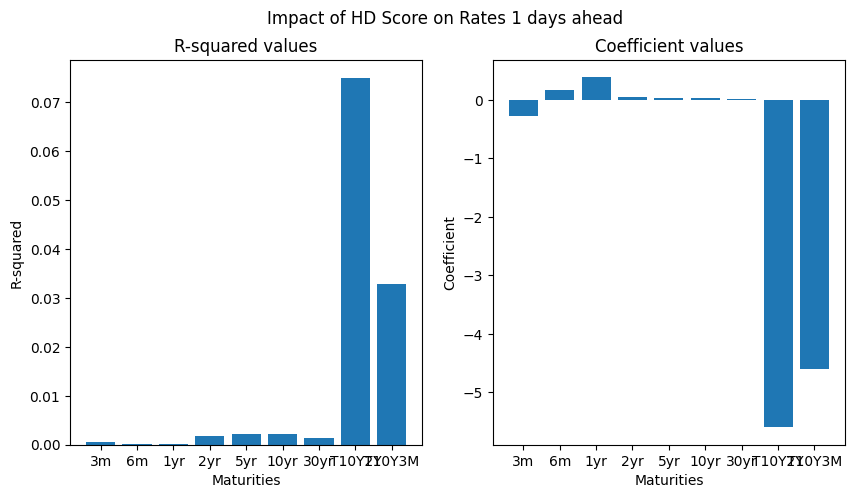

In [40]:
# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Create the bar chart for R-squared values
axs[0].bar(prices_list, rsquared_list_shift1)
axs[0].set_title('R-squared values')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('R-squared')

# Create the bar chart for coefficient values
axs[1].bar(prices_list, hd_coeff_list_shift1)
axs[1].set_title('Coefficient values')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')

# Show the plot
fig.suptitle(f"Impact of HD Score on Rates {shift1} days ahead")
plt.show()

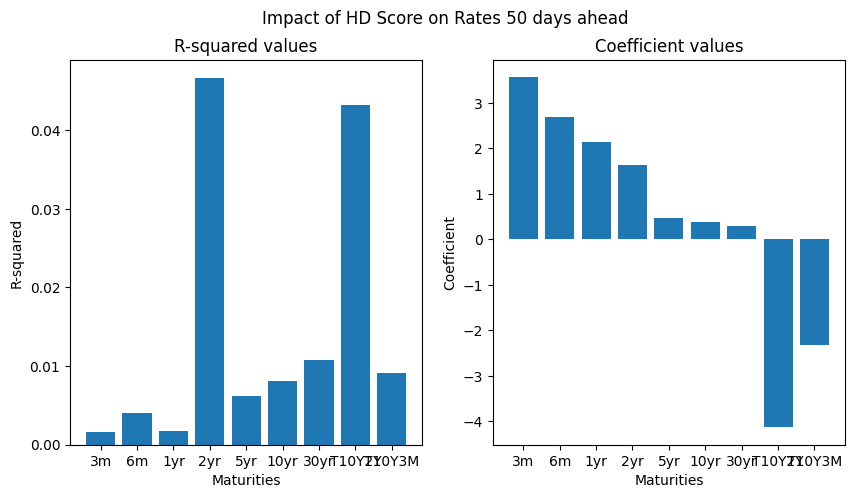

In [41]:
# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Create the bar chart for R-squared values
axs[0].bar(prices_list, rsquared_list_shift4)
axs[0].set_title('R-squared values')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('R-squared')

# Create the bar chart for coefficient values
axs[1].bar(prices_list, hd_coeff_list_shift4)
axs[1].set_title('Coefficient values')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')

# Show the plot
fig.suptitle(f"Impact of HD Score on Rates {shift4} days ahead")
plt.show()

In [14]:
import pandas as pd

# Create the DataFrame
df = pd.DataFrame(index=prices_list)

# Add the column from the list
df['1d'] = np.round(hd_pvalue_list_shift1, 5)
df['7d'] = np.round(hd_pvalue_list_shift2, 5)
df['14d'] = np.round(hd_pvalue_list_shift3, 5)
df['100d'] = np.round(hd_pvalue_list_shift4, 8)

# Show the result
print((df<0.05))

           1d     7d    14d  100d
3m      False  False  False  True
6m      False  False   True  True
1yr     False  False  False  True
2yr     False   True   True  True
5yr      True   True   True  True
10yr     True  False   True  True
30yr     True   True   True  True
T10Y2Y   True   True   True  True
T10Y3M   True   True   True  True


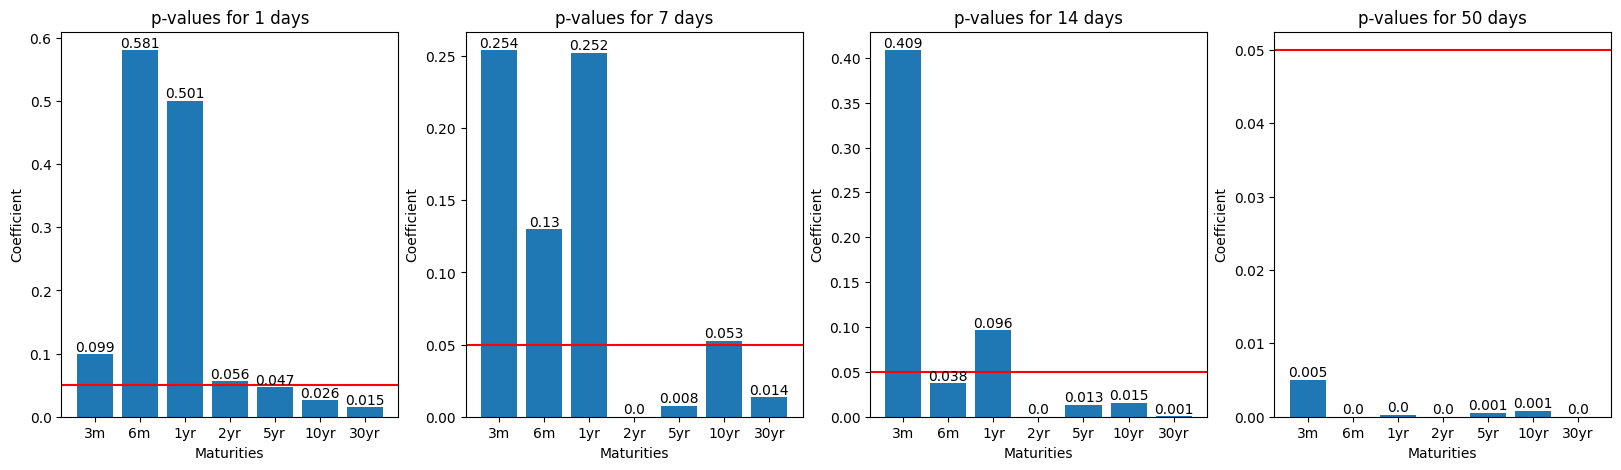

In [15]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for coefficient values for 1d
bars = axs[0].bar(prices_list[0:-2], hd_pvalue_list_shift1[0:-2])
axs[0].set_title(f'p-values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('Coefficient')
axs[0].axhline(y=0.05, color='r', linestyle='-')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 1w
bars = axs[1].bar(prices_list[0:-2], hd_pvalue_list_shift2[0:-2])
axs[1].set_title(f'p-values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')
axs[1].axhline(y=0.05, color='r', linestyle='-')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 2w
bars = axs[2].bar(prices_list[0:-2], hd_pvalue_list_shift3[0:-2])
axs[2].set_title(f'p-values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('Coefficient')
axs[2].axhline(y=0.05, color='r', linestyle='-')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 3w
bars = axs[3].bar(prices_list[0:-2], hd_pvalue_list_shift4[0:-2])
axs[3].set_title(f'p-values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('Coefficient')
axs[3].axhline(y=0.05, color='r', linestyle='-')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Show the plot
#fig.suptitle("Impact of HD Score on Rates")
plt.show()

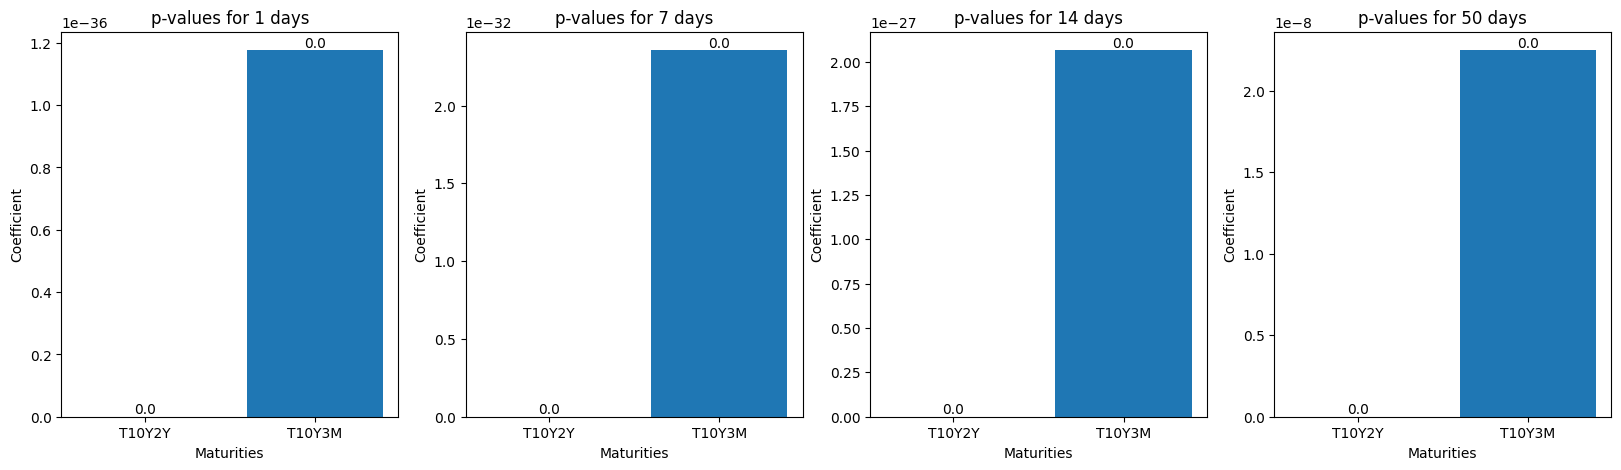

In [16]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for coefficient values for 1d
bars = axs[0].bar(prices_list[-2:], hd_pvalue_list_shift1[-2:])
axs[0].set_title(f'p-values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 1w
bars = axs[1].bar(prices_list[-2:], hd_pvalue_list_shift2[-2:])
axs[1].set_title(f'p-values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 2w
bars = axs[2].bar(prices_list[-2:], hd_pvalue_list_shift3[-2:])
axs[2].set_title(f'p-values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 3w
bars = axs[3].bar(prices_list[-2:], hd_pvalue_list_shift4[-2:])
axs[3].set_title(f'p-values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Show the plot
plt.show()

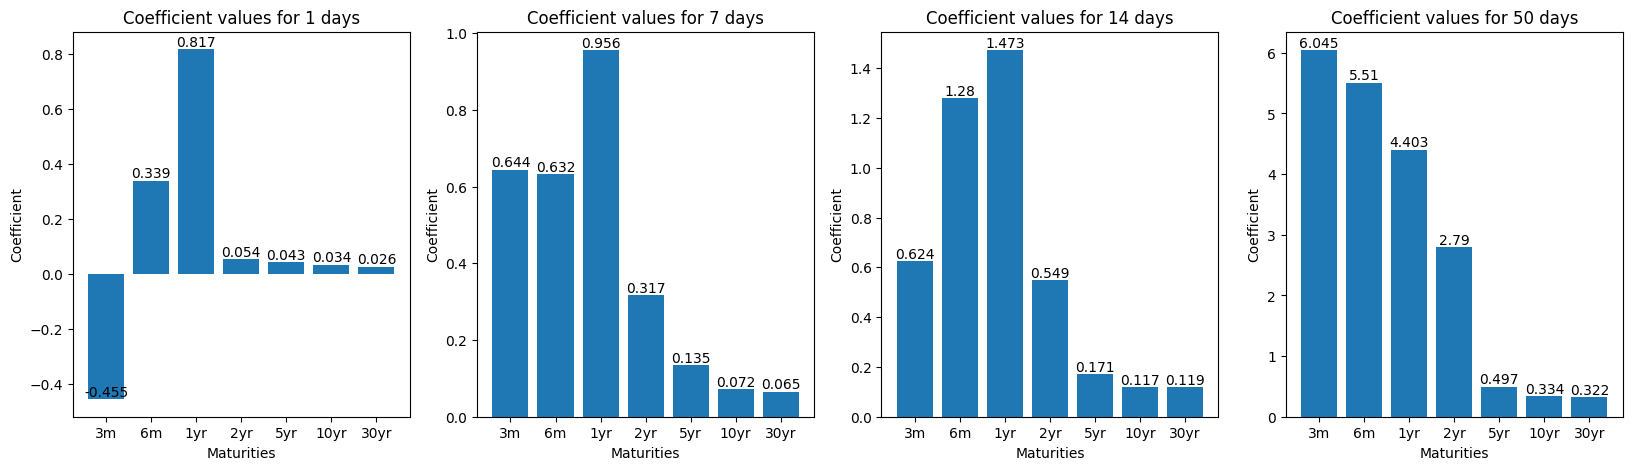

In [17]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for coefficient values for 1d
bars = axs[0].bar(prices_list[0:-2], hd_coeff_list_shift1[0:-2])
axs[0].set_title(f'Coefficient values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 1w
bars = axs[1].bar(prices_list[0:-2], hd_coeff_list_shift2[0:-2])
axs[1].set_title(f'Coefficient values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 2w
bars = axs[2].bar(prices_list[0:-2], hd_coeff_list_shift3[0:-2])
axs[2].set_title(f'Coefficient values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for coefficient values for 3w
bars = axs[3].bar(prices_list[0:-2], hd_coeff_list_shift4[0:-2])
axs[3].set_title(f'Coefficient values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Show the plot
plt.show()

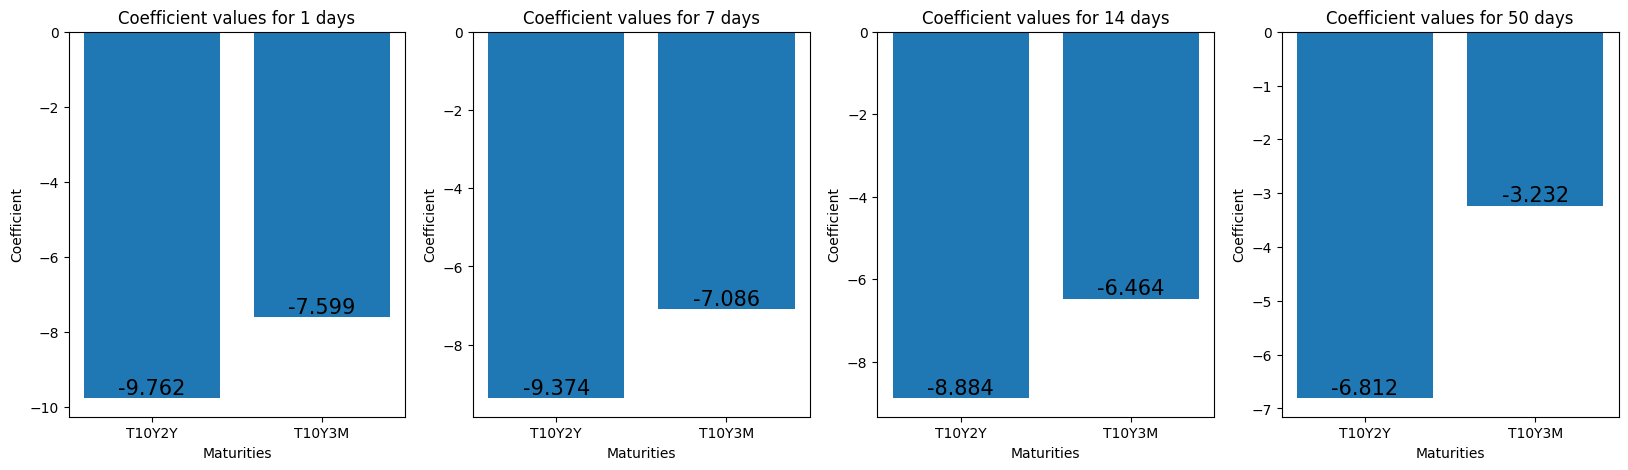

In [18]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for coefficient values for 1d
bars = axs[0].bar(prices_list[-2:], hd_coeff_list_shift1[-2:])
axs[0].set_title(f'Coefficient values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=15)

# Create the bar chart for coefficient values for 1w
bars = axs[1].bar(prices_list[-2:], hd_coeff_list_shift2[-2:])
axs[1].set_title(f'Coefficient values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=15)

# Create the bar chart for coefficient values for 2w
bars = axs[2].bar(prices_list[-2:], hd_coeff_list_shift3[-2:])
axs[2].set_title(f'Coefficient values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=15)

# Create the bar chart for coefficient values for 3w
bars = axs[3].bar(prices_list[-2:], hd_coeff_list_shift4[-2:])
axs[3].set_title(f'Coefficient values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('Coefficient')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=15)

# Show the plot
#fig.suptitle("Impact of HD Score on Rates")
plt.show()

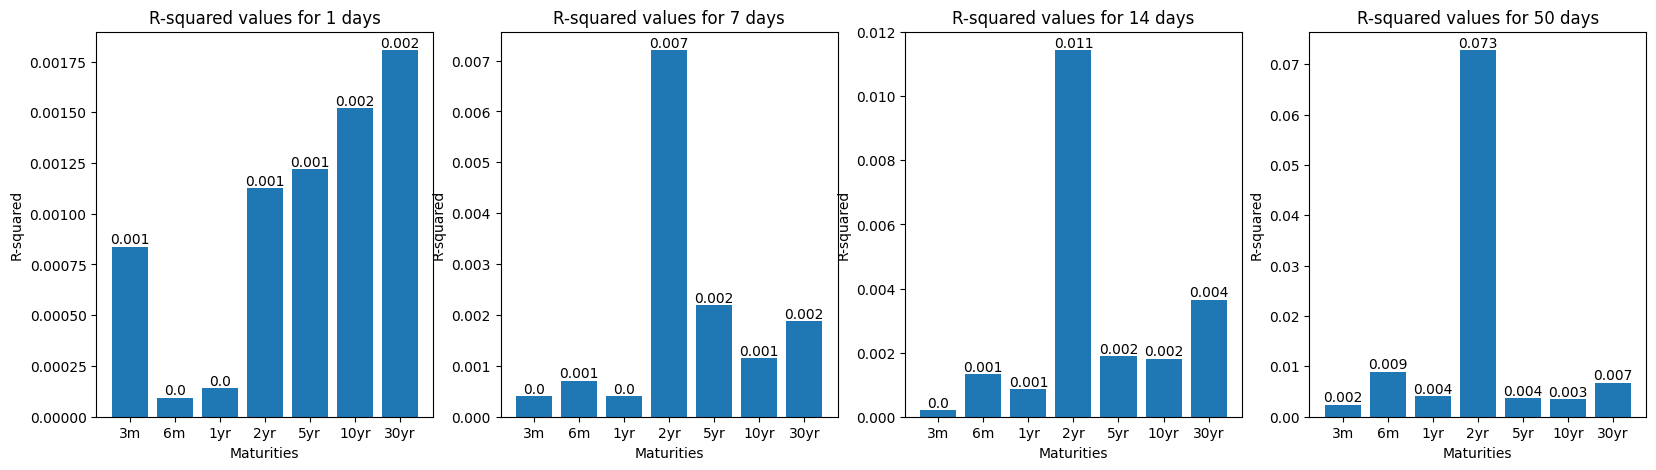

In [19]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for R-squared values for 1d
bars = axs[0].bar(prices_list[0:-2], rsquared_list_shift1[0:-2])
axs[0].set_title(f'R-squared values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for R-squared values for 1w
bars = axs[1].bar(prices_list[0:-2], rsquared_list_shift2[0:-2])
axs[1].set_title(f'R-squared values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for R-squared values for 2w
bars = axs[2].bar(prices_list[0:-2], rsquared_list_shift3[0:-2])
axs[2].set_title(f'R-squared values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Create the bar chart for R-squared values for 3w
bars = axs[3].bar(prices_list[0:-2], rsquared_list_shift4[0:-2])
axs[3].set_title(f'R-squared values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom')

# Show the plot
#fig.suptitle("Impact of HD Score on Rates")
plt.show()

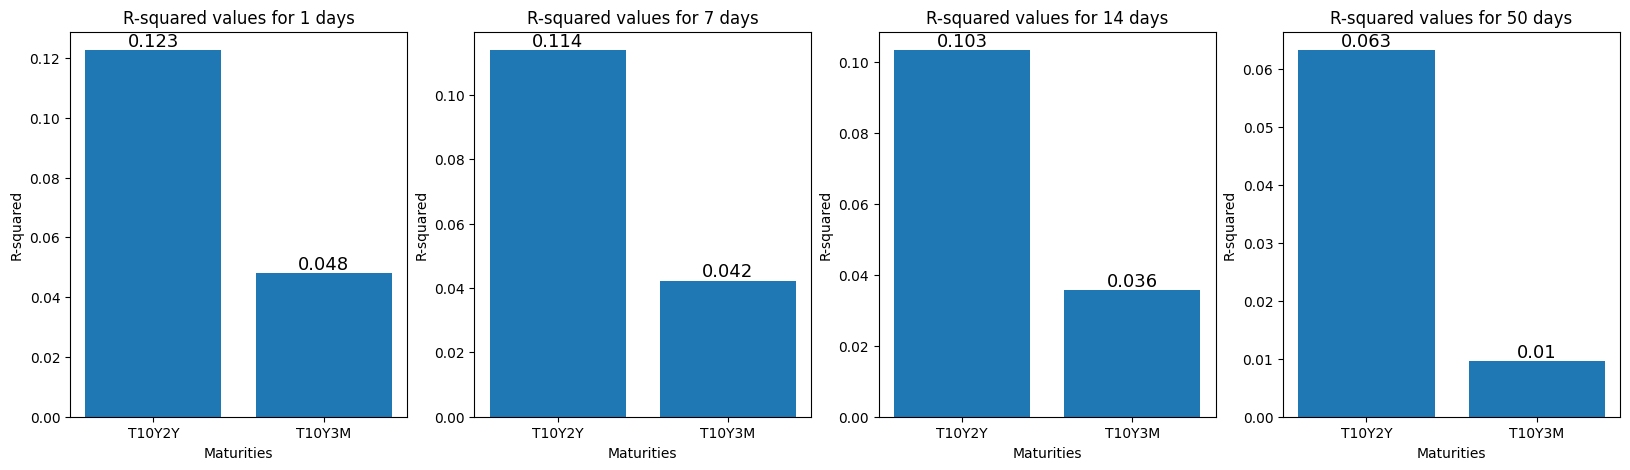

In [20]:
# Set up the figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Create the bar chart for R-squared values for 1d
bars = axs[0].bar(prices_list[-2:], rsquared_list_shift1[-2:])
axs[0].set_title(f'R-squared values for {shift1} days')
axs[0].set_xlabel('Maturities')
axs[0].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=13)

# Create the bar chart for R-squared values for 1w
bars = axs[1].bar(prices_list[-2:], rsquared_list_shift2[-2:])
axs[1].set_title(f'R-squared values for {shift2} days')
axs[1].set_xlabel('Maturities')
axs[1].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=13)

# Create the bar chart for R-squared values for 2w
bars = axs[2].bar(prices_list[-2:], rsquared_list_shift3[-2:])
axs[2].set_title(f'R-squared values for {shift3} days')
axs[2].set_xlabel('Maturities')
axs[2].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=13)

# Create the bar chart for R-squared values for 3w
bars = axs[3].bar(prices_list[-2:], rsquared_list_shift4[-2:])
axs[3].set_title(f'R-squared values for {shift4} days')
axs[3].set_xlabel('Maturities')
axs[3].set_ylabel('R-squared')

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, round(height, 3), ha='center', va='bottom', fontsize=13)

# Show the plot
#fig.suptitle("Impact of HD Score on Rates")
plt.show()

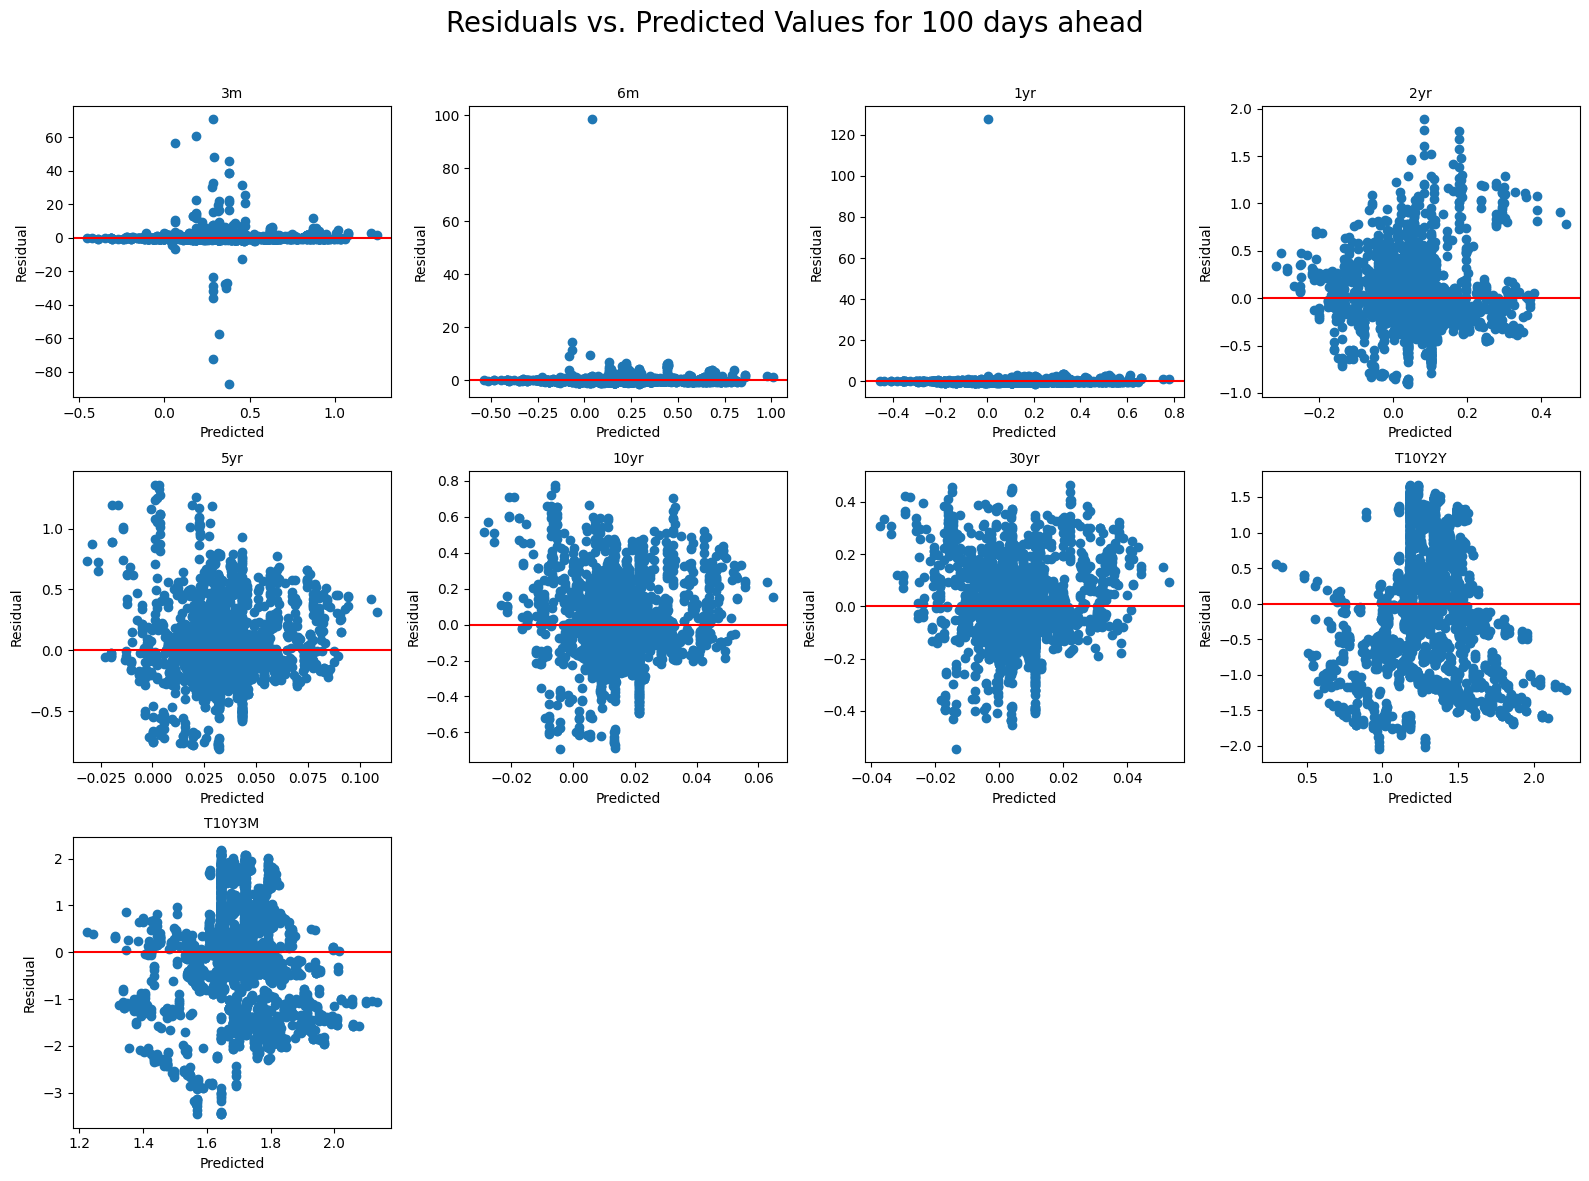

In [22]:
import numpy as np
import math

# calculate number of rows needed for subplots
n = len(prices_list)
rows = math.ceil(n/4)  # 4 graphs per row

fig, axs = plt.subplots(rows, 4, figsize=(16, 4*rows))
fig.suptitle('Residuals vs. Predicted Values for 100 days ahead', fontsize=20)

# Flatten the array of axes, for easier iteration
axs = axs.flatten()

for i in range(n):
    axs[i].scatter(pred_list_shift4[i], residuals_list_shift4[i])
    axs[i].axhline(y=0, color="r")
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Residual')
    axs[i].set_title(prices_list[i], fontsize=10)

# Remove unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top space, so the title does not overlap
plt.show()


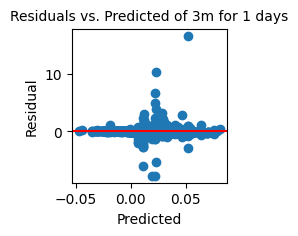

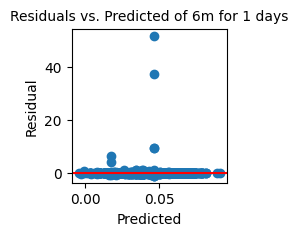

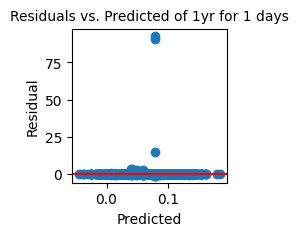

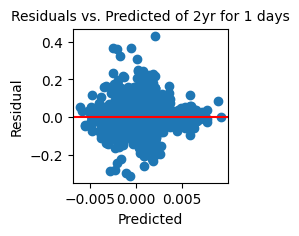

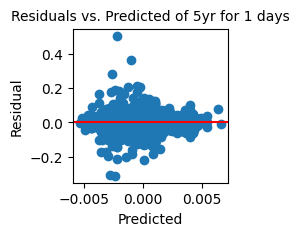

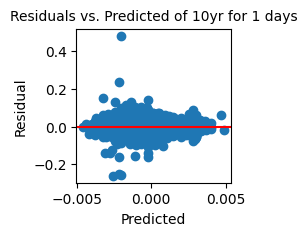

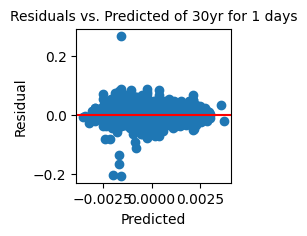

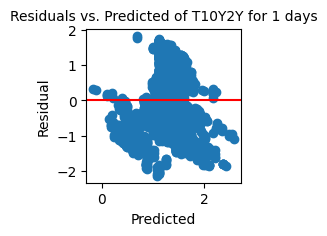

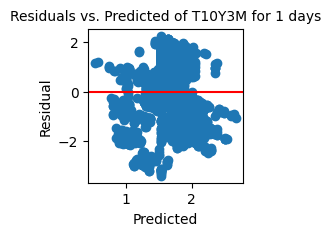

In [23]:
for i in range(len(prices_list)):
    fig, axs = plt.subplots(figsize=(2, 2))
    axs.scatter(pred_list_shift1[i], residuals_list_shift1[i])
    axs.axhline(y=0, color="r")
    axs.set_xlabel('Predicted')
    axs.set_ylabel('Residual')
    axs.set_title(f"Residuals vs. Predicted of {prices_list[i]} for {shift1} days", fontsize=10)
    plt.show()

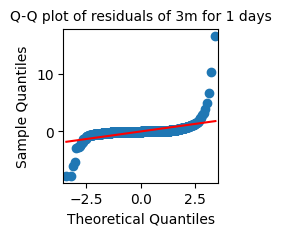

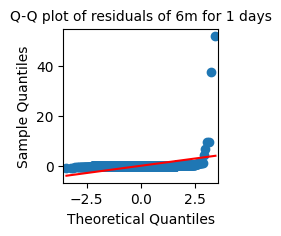

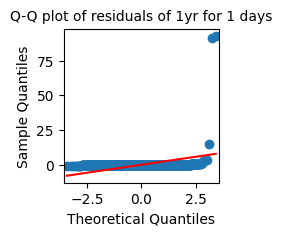

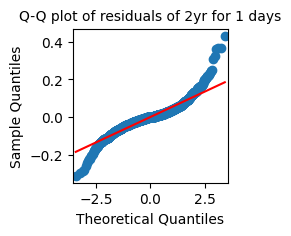

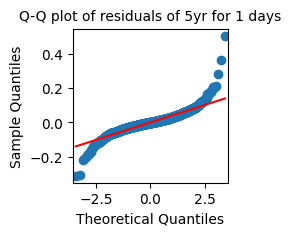

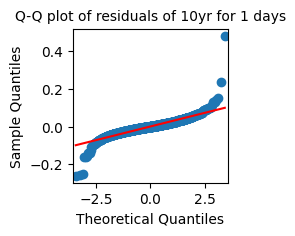

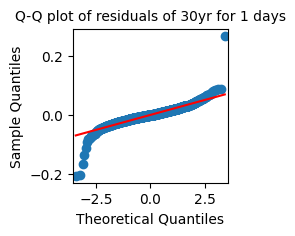

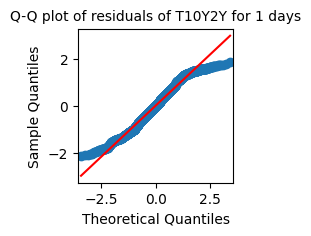

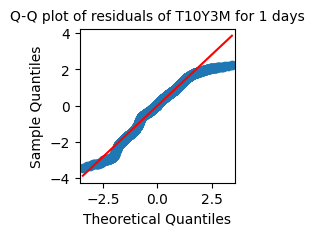

In [24]:
import statsmodels.api as sm
#plt.rcParams["figure.figsize"] = (3, 3)

for i in range(len(prices_list)):
    fig = sm.qqplot(residuals_list_shift1[i], line='s')
    fig.set_size_inches(2, 2)
    plt.title(f"Q-Q plot of residuals of {prices_list[i]} for {shift1} days", fontsize=10)
    plt.show()

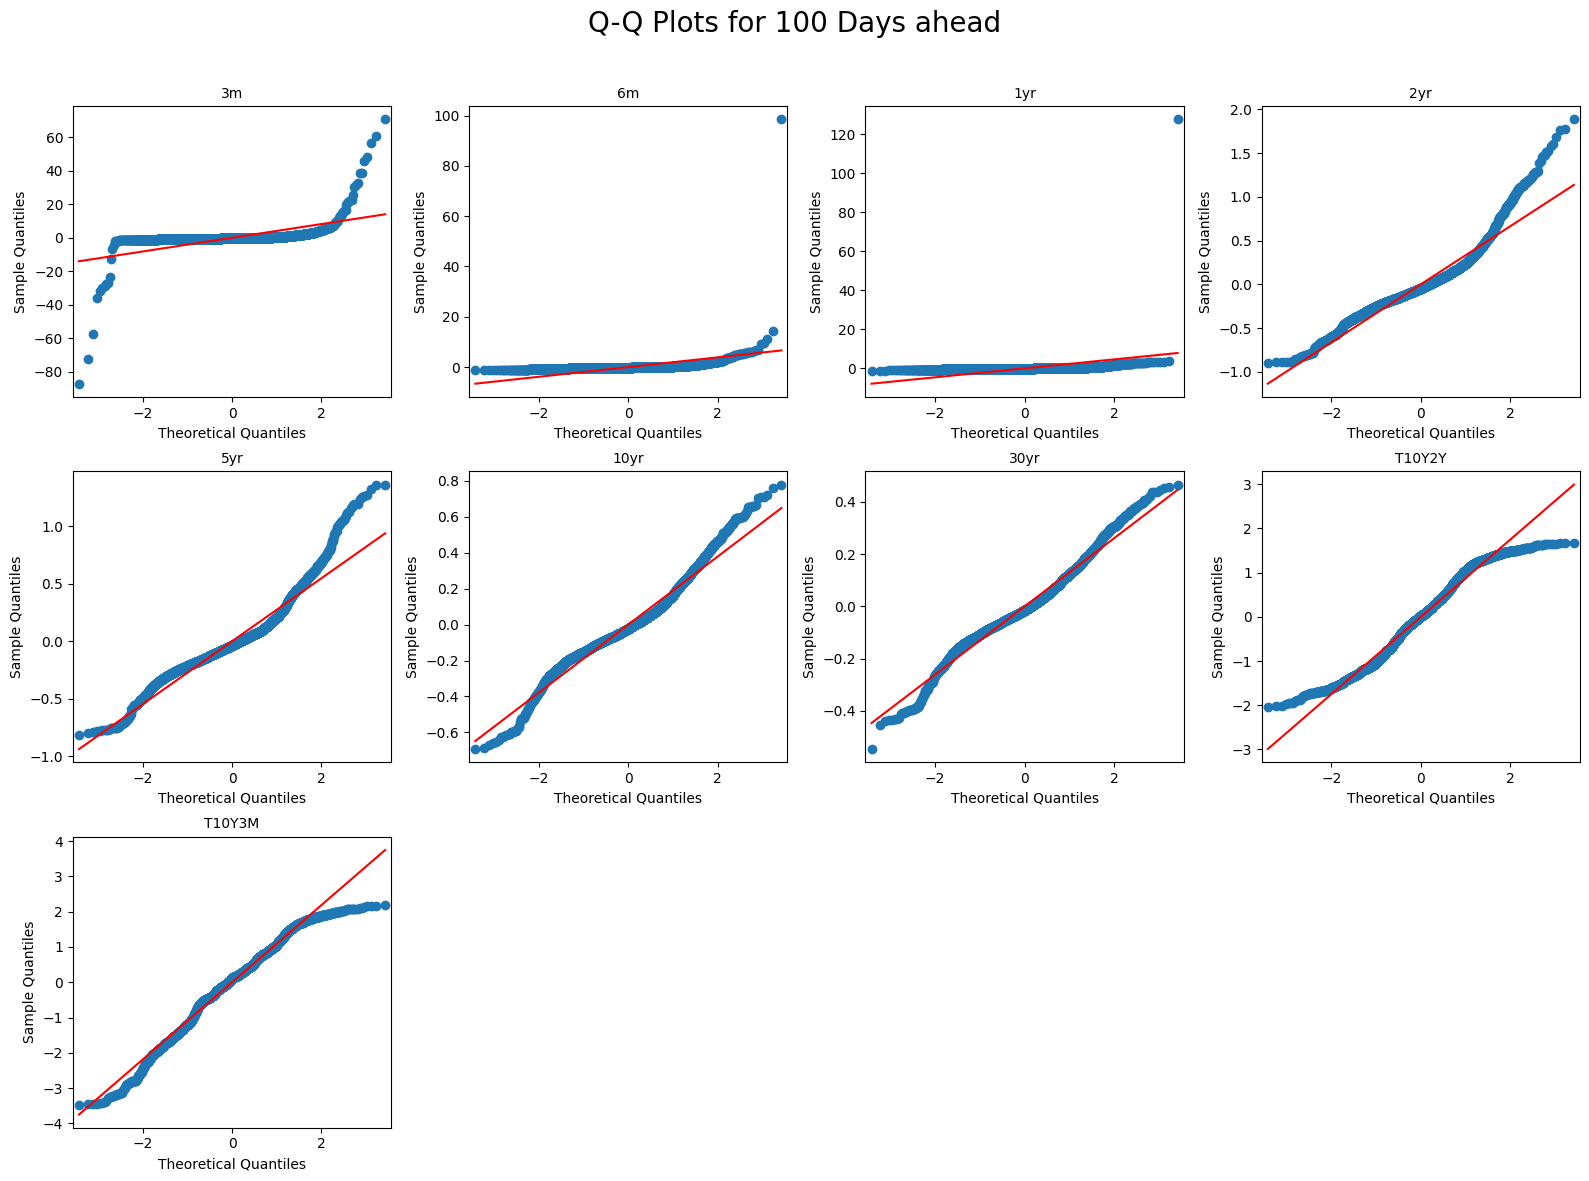

In [25]:
from statsmodels.graphics.gofplots import ProbPlot
import matplotlib.pyplot as plt
import math

n = len(prices_list)
rows = math.ceil(n/4)  # 4 graphs per row

fig, axs = plt.subplots(rows, 4, figsize=(16, 4*rows))
fig.suptitle('Q-Q Plots for 100 Days ahead', fontsize=20)

# Flatten the array of axes, for easier iteration
axs = axs.flatten()

for i in range(n):
    pp = ProbPlot(residuals_list_shift4[i])
    pp.qqplot(line='s', ax=axs[i])
    axs[i].set_title(prices_list[i], fontsize=10)

# Remove unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top space, so the title does not overlap
plt.show()

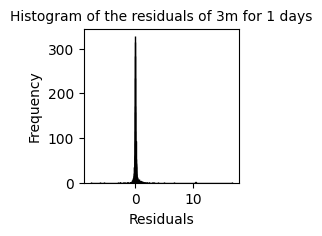

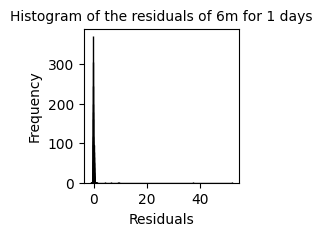

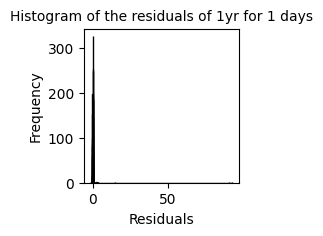

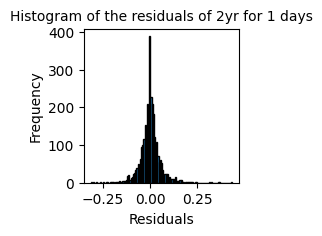

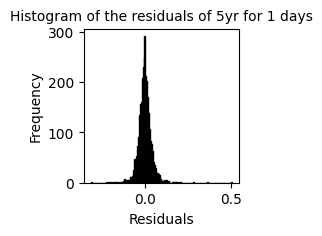

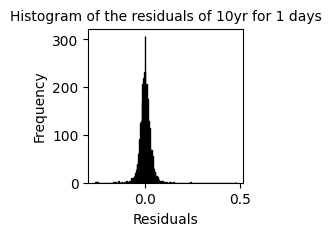

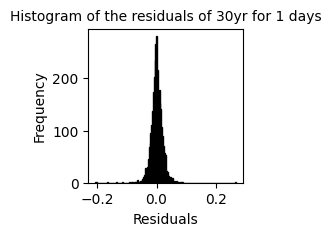

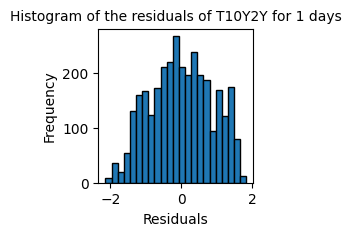

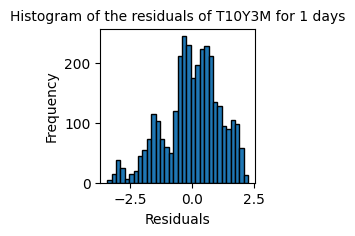

In [26]:
for i in range(len(prices_list)):
    fig, axs = plt.subplots(figsize=(2, 2))  # Set the figure size in inches
    axs.hist(residuals_list_shift1[i], bins='auto', histtype='bar', ec='k') 
    axs.set_xlabel("Residuals")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Histogram of the residuals of {prices_list[i]} for {shift1} days", fontsize=10)
    plt.show()


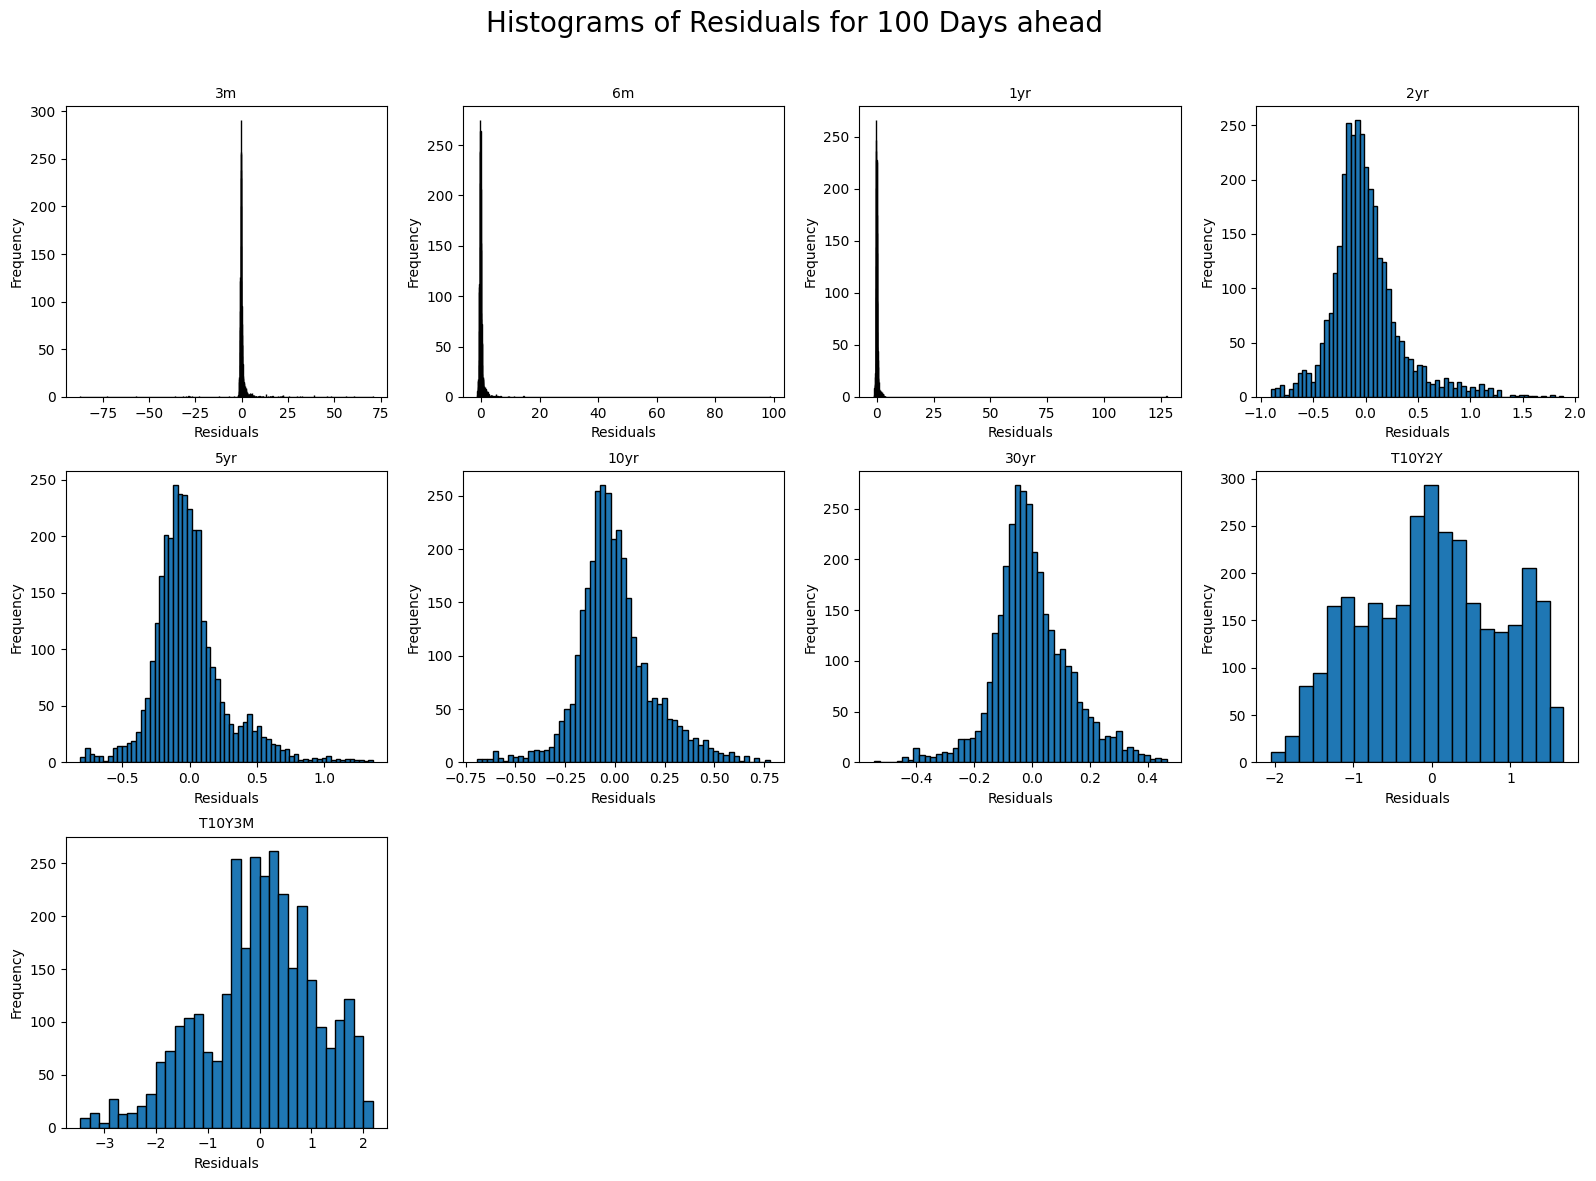

In [27]:
import math

n = len(prices_list)
rows = math.ceil(n/4)  # 4 graphs per row

fig, axs = plt.subplots(rows, 4, figsize=(16, 4*rows))
fig.suptitle('Histograms of Residuals for 100 Days ahead', fontsize=20)

# Flatten the array of axes, for easier iteration
axs = axs.flatten()

for i in range(n):
    axs[i].hist(residuals_list_shift4[i], bins='auto', histtype='bar', ec='k')
    axs[i].set_xlabel("Residuals")
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(prices_list[i], fontsize=10)

# Remove unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top space, so the title does not overlap
plt.show()


In [28]:
from scipy import stats

for i in range(len(prices_list)):
    shapiro_test = stats.shapiro(residuals_list_shift4[i])
    print(f"Shapiro-Wilk Test for residuals of {prices_list[i]} for {shift4} days: Statistic:{shapiro_test[0]} - p-value smaller than 0.05 = {shapiro_test[1] < 0.05}")


Shapiro-Wilk Test for residuals of 3m for 50 days: Statistic:0.22064805030822754 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 6m for 50 days: Statistic:0.14698386192321777 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 1yr for 50 days: Statistic:0.060634493827819824 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 2yr for 50 days: Statistic:0.9173135161399841 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 5yr for 50 days: Statistic:0.9280617833137512 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 10yr for 50 days: Statistic:0.9609279632568359 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of 30yr for 50 days: Statistic:0.9756030440330505 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of T10Y2Y for 50 days: Statistic:0.9753730893135071 - p-value smaller than 0.05 = True
Shapiro-Wilk Test for residuals of T10Y3M for 50 days: Statistic: